<a href="https://colab.research.google.com/github/siddharthchd/introml/blob/master/unit5/demo2_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo:  House Price Feature Selection with LASSO 

In this demo, we illustrate the classic technique of LASSO regularization as a feature selection method.
You will learn to:

* Identify and one-hot code categorical variables
* Scale data before processing
* Fit a LASSO model 
* Determine the regularization level with cross-validation
* Draw the coefficient path as a function of the regularization level

The data for this demo comes from this excellent 
[Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) on predicting
housing prices.  The data was developed by Dean DeCock at Truman State University in the nice 
[paper](http://jse.amstat.org/v19n3/decock.pdf).

There is another demo in this repository on the Prostate cancer dataset that was used in earlier versions
of this class.  But, this dataset somewhat better illustrates the need for feature selection.

First, we load the regular packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Downloading and Cleaning the Data

On the Kaggle competition site, you can download a train data set (with labels) and a test data set (with no labels).  Here, we will just use the train dataset since it has labels that we can use to assess the results.  Later, we will split that dataset into training and test. 

In [4]:
fn_src = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit05_lasso/housing_train.csv'
fn_dst = 'housing_train.csv'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
  print('File {} is already downloaded.'.format(fn_dst))
else:
  urllib.request.urlretrieve(fn_src, fn_dst)

In [5]:
df = pd.read_csv('housing_train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We print the number of attributes and samples.  We see that there are a large number of attributes for each home sale.

In [6]:
nsamp, natt = df.shape
print('Number of samples = %d' % nsamp)
print('Number of attributes = %d' % natt)

Number of samples = 1460
Number of attributes = 81


Before we proceed, we need to remove the columns with missing values. We see that we remove about 19 attributes.

In [7]:
df = df.dropna(axis = 1)

nsamp, natt = df.shape
print('Number of samples = %d' % nsamp)
print('Number of attributes = %d' % natt)

Number of samples = 1460
Number of attributes = 62


It is suggested in DeCock's [paper](http://jse.amstat.org/v19n3/decock.pdf), that to make the regression easier, we remove all the entries where the `SaleCondition` was not normal.  We do this with the following code which should leave us with 1198 samples.

In [8]:
df = df.loc[df['SaleCondition'] == 'Normal']

nsamp, natt = df.shape
print('Number of samples = %d' % nsamp)
print('Number of attributes = %d' % natt)

Number of samples = 1198
Number of attributes = 62


## One-Hot Coding the Categorical Variables

You will see there are a large number of variables that are *categorical* meaning they are one of a few discrete values.  
We can use the `df.dtypes` to get the type of each variable.  Categorial variables have type `object`.  

In [11]:
print(df.dtypes)

Id                int64
MSSubClass        int64
MSZoning         object
LotArea           int64
Street           object
                  ...  
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
SalePrice         int64
Length: 62, dtype: object


We want to one hot code all the categorical variables.  As a first step, a first list `cat_vars` with all the categorical variables and `real_vars` with the real variables (i.e. non-categorical).   In both lists we do not include the variables `ignore_vars` which include the index, month of the sale or sales price (the sales price) will be used as the target.

In [14]:
# Remove the ID, month sold and sales price (it is the target)
ignore_vars = ['Id', 'MoSold', 'SalePrice']

# Find real and categorical variables
cols = df.columns
real_vars = []
cat_vars = []

for col in cols:

  if col not in ignore_vars:
    if df.dtypes[col] == 'object':
      cat_vars.append(col)
    else:
      real_vars.append(col)
  
print('Categorical variables = {}'.format(cat_vars))
print('')
print('Real variables = {}'.format(real_vars))

Categorical variables = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Real variables = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']


We next one-hot coded categorical variables.  To do this, we use the `pd.get_dummies` command to convert the categorical variables to one hot coded items.   We use the `drop_first=True` to replace each category with `k` values to `k-1` variables.  This removes linearly dependent columns.

In [17]:
# Get the dataframes with real and categorical variables
df_real = df[real_vars]
df_cat = df[cat_vars]

# One-hot encode the categorical variables
df_cat_en = pd.get_dummies(df_cat, drop_first = True)

To see how the one hot coding worked, we print out the original categorical table, `df_cat` and the one hot coded variables `df_cat_enc`.  Observe how a variable like `MSZoning` is converted to multiple columns like `MSZoning_C`, `MSZoning_FV`, ..., `MSZoning_RM` corresponding to each possible value.  

In [18]:
df_cat.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,GasA,Ex,Y,TA,Typ,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
5,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,VinylSd,VinylSd,TA,TA,Wood,GasA,Ex,Y,TA,Typ,Y,WD,Normal


In [20]:
df_cat_en.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,...,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_WD
0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
4,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
5,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1


To get the data matrix, we then concatanate the real and encoded categorical tables and convert to an array.  We see there are now 214 attributes.

In [21]:
df_enc = pd.concat((df_real, df_cat_en), axis = 1)
X = np.array(df_enc)
print(X.shape)

xnames = df_enc.columns

(1198, 174)


To get the target we extract the sales price

In [22]:
y = np.array(df['SalePrice'])

## Scaling the Data

We will try to fit a model with simple linear regression.   We first split the data into training and test.

In [23]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3)

A feature of this data is that the attributes have very different ranges of values.  Many methods below expect that the variables have similar ranges.  For this purpose we use sklearn's `StandardScaler` which removes the mean from each column and divides by the standard deviation.  We fit the parameters for the scaler on the training data and then apply the transform to the training and test data.

Technically, we do not need to scale the output, but it will make the variables easier to interpret.

In [26]:
from sklearn.preprocessing import StandardScaler

# Create the scalar objects
xscaler = StandardScaler()
yscaler = StandardScaler()

# Fit and transform the training data
Xtrain1 = xscaler.fit_transform(Xtrain)
ytrain1 = yscaler.fit_transform(ytrain[:, None])

# Transfrom the test data
Xtest1 = xscaler.fit_transform(Xtest)
ytest1 = yscaler.fit_transform(ytest[:, None])

## Linear Regression without Regualarization

We first fit the model with linear regression on the scaled training data.  Then, we predict on the test data and measure the R^2 value.  We get a terrible fit.

In [27]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

# Fit
reg_ls = LinearRegression()
reg_ls.fit(Xtrain1, ytrain1)

# Training R square
yhat1_train = reg_ls.predict(Xtrain1)
rsq_train = r2_score(yhat1_train, ytrain1)
print('Training R square = {}'.format(rsq_train))

# Test R square
yhat1_test = reg_ls.predict(Xtest1)
rsq_test = r2_score(yhat1_test, ytest1)
print('Testing R square = {}'.format(rsq_test))

Training R square = 0.9456217044222812
Testing R square = 2.4591439995447217e-13


We get a terrible fit.  The reason is that the matrix is ill-conditioned, meaning some of the columns in the data matrix `Xtr` are linearly dependent.  We can get a better fit if we use a method called *Ridge regression*.  Ridge regression is a type of regularization that we will discuss later, but we will use it here simply to improve the conditioning.  

To understand Ridge regression, recall that the solution of the LS problem is:

    beta = inv(A.T.dot(A)).dot(A.T.dot(y))
    
The problem occurs when the matrix, `A.T.dot(A)` has eigenvalues close to zero so the inverse blows up.  To avoid, Ridge regression instead computes,

    beta = inv(A.T.dot(A) + n*alpha*eye(n)).dot(A.T.dot(y))

where `n` is the number of data samples and `alpha` is a small value to keep the eigenvalues positive.  Ridge regression can be performed as follows.

In [28]:
reg_ls = Ridge(alpha = 1e-5)
reg_ls.fit(Xtrain1, ytrain1)
yhat1 = reg_ls.predict(Xtest1)
rsq = r2_score(yhat1, ytest1)
print('Test R^2 : {}'.format(rsq))

Test R^2 : 0.8458745781986996


We see we get a good fit. We can also plot the actual vs predicted values. To do this, we convert the predicted targets back to the original scaling with the `inverse_transform` method in the scaler.

Text(0, 0.5, 'Actual')

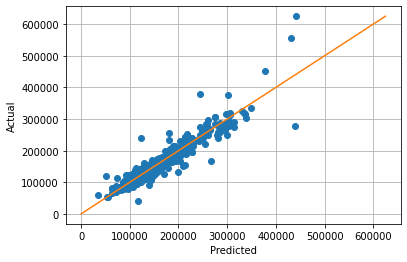

In [29]:
yhat = yscaler.inverse_transform(yhat1)

yline = np.array([0, np.max(ytest)])
plt.plot(yhat, ytest, 'o')
plt.plot(yline, yline)
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('Actual')

To understand which variables are important, we may find the variables with the largest coefficients. We see that among the top 10 coefficients, attributes such as square footage (SF) and quality dominate.

In [30]:
coeff_ls = reg_ls.coef_.ravel()
nprint = 10
I = np.argsort(np.abs(coeff_ls))
I = np.flipud(I)

for i in range(nprint):
  j = I[i]
  print('%20s %f' % (xnames[j], coeff_ls[j]))

           GrLivArea 0.275571
 Exterior1st_CemntBd 0.240827
      KitchenQual_Gd -0.231837
      KitchenQual_TA -0.218965
            2ndFlrSF 0.218912
 Exterior2nd_CmentBd -0.204457
        ExterQual_TA -0.168233
           YearBuilt 0.163554
        ExterQual_Gd -0.134817
     RoofStyle_Gable 0.134283


We can also try to find the variables that do not matter. But this is harder since it appears that most coeffiecients are non-zero. We can see this from both the stem plot (left) and the sorted coefficients (right). It is hard to discard any coefficients.

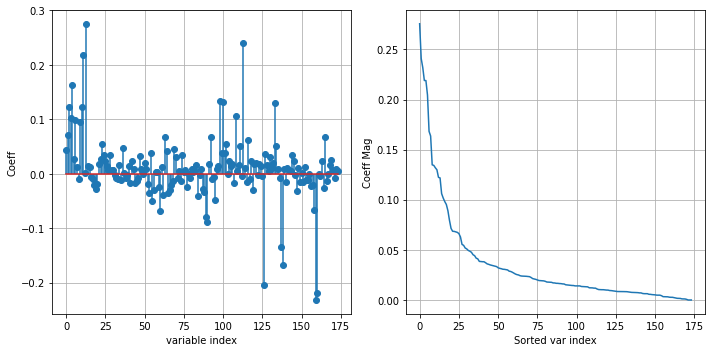

In [31]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.stem(coeff_ls, use_line_collection = True)
plt.xlabel('variable index')
plt.ylabel('Coeff')
plt.grid()

plt.subplot(1, 2, 2)
coeff_sort_ls = np.flipud(np.sort(np.abs(coeff_ls)))
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.tight_layout()

-3490310.356541098
